[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/git-sunao/path-integral/blob/main/test9.ipynb)

In [1]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

In [2]:
# general
import os
import numpy as np
from tqdm import tqdm
# jax
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit
from jax import grad
from jax import vmap
from jax import jacobian
from jax import jacfwd, jacrev
from jax import vjp
from jax.lax import scan
# plotting
import matplotlib.pyplot as plt
import arviz
from getdist import plots, MCSamples
# numpyro
import numpyro
import numpyro.distributions as npyro_dist
from numpyro.infer import MCMC, NUTS
# # NF
import torch
import pyro
import pyro.distributions as pyro_dist
import pyro.distributions.transforms as T
smoke_test = ('CI' in os.environ)
%matplotlib inline
cpu_device = jax.devices('cpu')[0]

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Development notebook 9
Adding the annealing parameter to the MAF model.

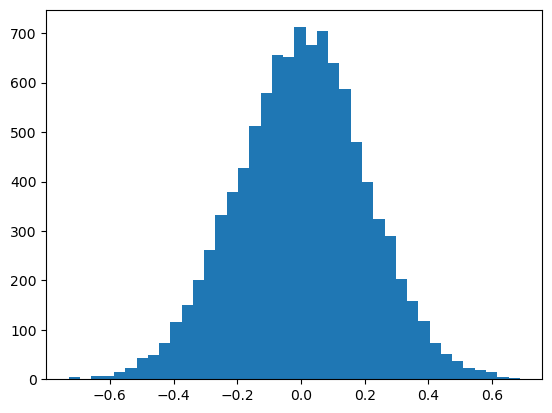

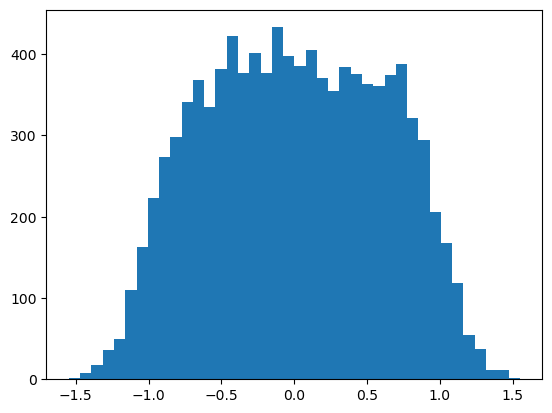

In [39]:
n = 10000
rng = np.random.default_rng(10)
y = rng.uniform(-1, 1, n)
# x = np.hstack([rng.normal(0,0.2, n-n//4), rng.normal(0.6,0.1, n//4)])
x = rng.normal(0.0, 0.2,n)

plt.hist(x, bins=40)
plt.show()

plt.hist(x+y, bins=40)
plt.show()

In [40]:
samples = np.vstack([y, x+y]).T

In [41]:
samples.shape

(10000, 2)

In [42]:
import flax.linen as nn
import optax
from sklearn import datasets, preprocessing
from tqdm import tqdm

import sys
sys.path.append("../")

from models.maf import MaskedAutoregressiveFlow
from models.nsf import NeuralSplineFlow

n_dim = ndim = 1  # Feature dim
n_context = 1  # Context dim

## Define flow model
model = MaskedAutoregressiveFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[128,128], n_transforms=12, activation="tanh", use_random_permutations=False)

## Initialize model and params
key = jax.random.PRNGKey(42)
x_test = jax.random.uniform(key=key, shape=(64, n_dim))
context = jax.random.uniform(key=key, shape=(64, n_context))
params = model.init(key, x_test, context)

In [43]:
optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(params)

def loss_fn(params, x, context):
  loss = -jnp.mean(model.apply(params, x, context))
  return loss

@jax.jit
def update(params, opt_state, batch):
  x, context = batch
  grads = jax.grad(loss_fn)(params, x, context)
  updates, new_opt_state = optimizer.update(grads, opt_state, params)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [44]:
%%time
batch_size = 64
# n_steps = 10_000
# n_steps = 1_000
n_steps = 100
loss_history = []

key = jax.random.PRNGKey(0)
for step in tqdm(range(n_steps)):
    # Generate random batch
    # data_batch = samples[np.random.choice(samples.shape[0], batch_size)]
    key, subkey = jax.random.split(key) # Split key
    indices = jax.random.choice(subkey, n, shape=(batch_size,), replace=False)
    data_batch = samples[indices]
    x_batch = data_batch[:,:ndim]
    y_batch = data_batch[:,ndim:]

    # Update
    batch = (x_batch, y_batch)
    params, opt_state = update(params, opt_state, batch)

    # Save loss
    loss_history.append(loss_fn(params, x_batch, y_batch))

100%|██████████| 100/100 [00:24<00:00,  4.01it/s]

CPU times: user 23.7 s, sys: 1.04 s, total: 24.8 s
Wall time: 24.9 s


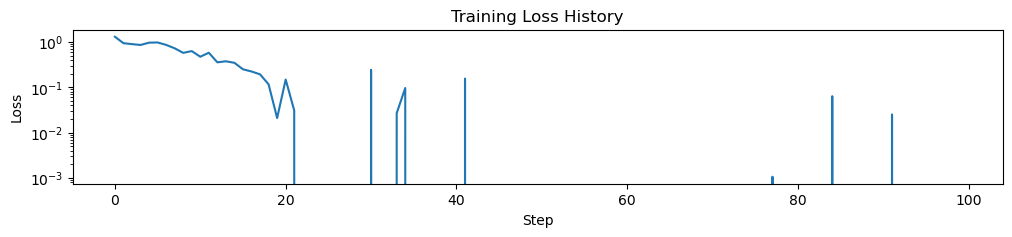

In [45]:
# Plot loss
plt.figure(figsize=(12, 2))
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

In [46]:
def sample_from_flow(y, n_samples=10_000, key=jax.random.PRNGKey(42), w=1.0):
    """Helper function to sample from the flow model.
    """
    if len(y.shape) == 1:
        y = jnp.ones((n_samples, n_context))*y[None, :]
    assert y.shape == (n_samples, n_context), f"Context shape should be (n_samples, n_context), got {y.shape}"

    def sample_fn(model):
        x_samples = model.sample(num_samples=n_samples, rng=key, 
                        context=y, beta=w)
        return x_samples

    x_samples = nn.apply(sample_fn, model)(params)
    x_samples = jnp.array(x_samples)
    return x_samples

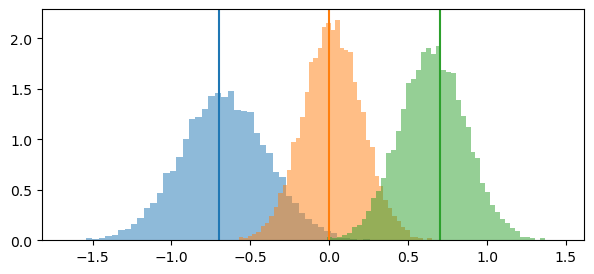

In [47]:
plt.figure(figsize=(7, 3))
for j, y in enumerate([-0.7, 0.0, 0.7]):
    _ = jnp.array([y]+[0]*(ndim-1))
    x = sample_from_flow(y=_, n_samples=10_000, key=jax.random.PRNGKey(42))
    plt.hist(x[:,0], bins=50, density=True, alpha=0.5, label="Flow", color='C{}'.format(j))
    plt.axvline(y, color='C{}'.format(j))
plt.show()

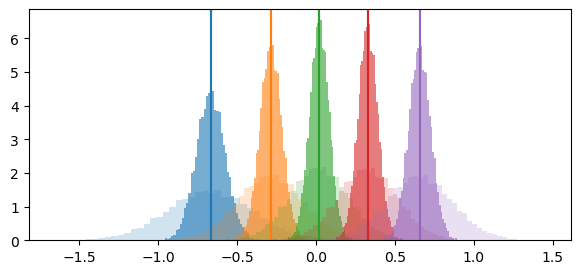

In [49]:
plt.figure(figsize=(7, 3))
for j, y in enumerate([-0.7, -0.3, 0.0, 0.3, 0.7]):
    _ = jnp.array([y]+[0]*(ndim-1))
    x = sample_from_flow(y=_, n_samples=10_000, key=jax.random.PRNGKey(42))
    plt.hist(x[:,0], bins=50, density=True, alpha=0.2, label="Flow", color='C{}'.format(j))
    plt.axvline(np.mean(x[:,0]), color='C{}'.format(j))
    x = sample_from_flow(y=_, n_samples=10_000, key=jax.random.PRNGKey(42), w=3.0)
    plt.hist(x[:,0], bins=50, density=True, alpha=0.6, label="Flow", color='C{}'.format(j))
    plt.axvline(np.mean(x[:,0]), color='C{}'.format(j))
plt.show()